<img src="https://s3.amazonaws.com/greenplum.org/wp-content/uploads/2018/11/14180216/logo-gpdb-light.svg" alt="drawing" width="200"/>

# Data Science Workshop

This notebook serves as an hands-on introduction to the data science pipeline.  Using a single dataset throughout, it begins with loading the data from a Greenplum Database (GPDB), then proceeds to data exploration, feature engineering, model development, and finally, model evaluation.

We’ll be using the publicly available [Abalone dataset from the University of California, Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/abalone).  The dataset contains nine attributes (including our target prediction column).

| Column Name | Data Type | Description|
| ---|:---:| ---:|
|Sex | text | M,F,I[infant]|
| Length | float | Longest shell measurement|
|Diameter | float | Perpendicular to length|
| Height | float | With meat in shell |
| Whole weight | float | Whole abalone |
| Shucked weight | float | Weight of meat only |
| Viscera weight | float | Gut weight (after bleeding) |
| Shell weight | float | Post-drying |
| Rings | integer | +1.5 gives the age in years|

Much of the code to conduct this enterprise has already been filled in for you.  Where your input is required will be clear as it will say `## CODE HERE ##`.  You’ll replace those sections with the appropriate code snippets you learn as we go through this notebook together.

You should feel free to make as many comments and notes as is helpful for your future self (you can make an inline comment by beginning a line with the “#” character).

# Set Up Your Notebook Environment

In [67]:
# this command allows for visualizations to appear in the notebook
%matplotlib inline
import math
import six
import pandas as pd
from sqlalchemy import create_engine
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)

An optional visualization step in this notebook relies on the `graphviz` package.  The following will check to see if it's installed. If it's not installed you will be prompted to optionally install it now. In the event the you run into problems with package installation, please check the [graphviz download page](https://www.graphviz.org/download/) for more instructions.

In [68]:
graphviz_installed = True

try:
    import graphviz
except ImportError:
    print("installing graphviz")
    install_graphviz = six.moves.input('Install `graphviz`? (y/n)')
    if install_graphviz == 'y':
        !pip install graphviz
    else:
        raise ImportError
except:
    graphviz_installed = False
    print("Could not load or install graphviz. Will not show random forest visualization below. ")

# Connect to Database

Establishing the sql connection and loading the data into the GPDB is done behind the scenes here by calling a helper function from a custom module called `dbconnect` in the interest of getting more quickly to the sections on analytics.

In [69]:
import dbconnect

A prerequisite to establishing the sql connection to GPDB is a set of credentials stored in a .cred file.  The credential file contents should look something like below. 

    [database_creds]
    host: <HOSTNAME_OR_IP>
    port: 5432
    user: <USERNAME>
    database: <DATABASE_NAME>
    password: <PASSWORD>

The values in angle brackets (\<...\>) are placeholders that need to be filled in. For example:

    [database_creds]
    host: 1.2.3.4
    port: 5432
    user: scott
    database: practice_db
    password: my_$ecretP@ss

Running the `connect_and_register_sql_magic()` function below will add a global variable `conn` that is a SQLAlchemy connection object.

In [70]:
db_credential_file = 'db_credentials.txt'
dbconnect.connect_and_register_sql_magic(
    db_credential_file,
    conn_name='conn'
)

The sql_magic extension is already loaded. To reload it, use:
  %reload_ext sql_magic
Connection object assigned to `conn`


In [71]:
schema = 'ds_training'

## Load Abalone Data

An [abalone](https://simple.wikipedia.org/wiki/Abalone) is a salt water univalve mollusc.
We'll load the data from ```web external table``` then start looking at the data.

The external table may have been created by a DBA. If so, comment out the code below.

In [72]:
%%read_sql
---
--- The below code will create an external table that points at the data available at IMS/UCI.
---
drop external table if exists ext.abalone_web;
create external web table
    ext.abalone_web (
        sex char(1),
        length float,
        diameter float,
        height float,
        whole_weight float,
        shucked_weight float,
        viscera_weight float,
        shell_weight float,
        rings integer
    )
    location ( 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data' )
    format 'TEXT' ( delimiter ',' null '' )
    log errors
    segment reject limit 100
;
select * from ext.abalone_web limit 1
;

Query started at 01:39:52 PM EST; Query executed in 0.01 m

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15


In [73]:
%%read_sql
-- DROP SCHEMA IF EXISTS {schema} CASCADE;
-- CREATE SCHEMA {schema};
DROP TABLE IF EXISTS {schema}.abalone;
CREATE TABLE {schema}.abalone (
        id integer,
        sex char(1),
        length float,
        diameter float,
        height float,
        whole_weight float,
        shucked_weight float,
        viscera_weight float,
        shell_weight float,
        rings integer
    )
;
    
DROP SEQUENCE IF EXISTS abalone_id ;
CREATE TEMPORARY SEQUENCE abalone_id MINVALUE 0 START 0;

insert into 
     {schema}.abalone 
select 
      nextval('abalone_id') as id, *
FROM 
      ext.abalone_web
;


SELECT * FROM {schema}.abalone ORDER BY id LIMIT 5;

Query started at 01:39:53 PM EST; Query executed in 0.00 m

,id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### Load some data into a local variable, ```abalone```

In [74]:
%%read_sql -d abalone
select * from {schema}.abalone where random() < 1.0 order by id limit 5000;

Query started at 01:39:53 PM EST; Query executed in 0.00 m

### Understand the basic structure and contents of the ```dataframe```
One of the key steps in the data science life cycle is exploring the data.  Key aspects of the data to notice are the presence of null values and data types.

In [75]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
id                4177 non-null int64
sex               4177 non-null object
length            4177 non-null float64
diameter          4177 non-null float64
height            4177 non-null float64
whole_weight      4177 non-null float64
shucked_weight    4177 non-null float64
viscera_weight    4177 non-null float64
shell_weight      4177 non-null float64
rings             4177 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 326.5+ KB


## Looking at the Target
We're interested in estimating the age of the abalone in the data.  To get age, add 1.5 to the number of rings.  A good place to begin is to create a histogram of the target variable.

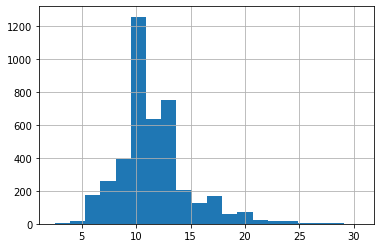

In [76]:
(abalone.rings + 1.5 ).hist(bins=20)

In [77]:
((abalone.rings + 1.5) >= 10).value_counts()

True     2770
False    1407
Name: rings, dtype: int64

### Look at the distribution using the cumulative sum

Text(0, 0.5, 'Normalized Cumulative Sum')

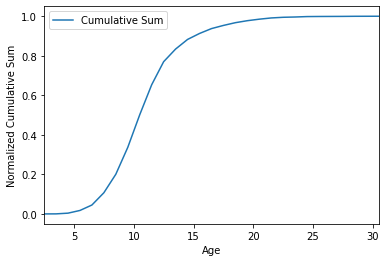

In [78]:
n_cumsum_df = pd.DataFrame({'Cumulative Sum':((abalone.rings + 1.5).value_counts().sort_index().cumsum())/abalone.shape[0]})
ax = n_cumsum_df.plot()
ax.set_xlabel('Age')
ax.set_ylabel('Normalized Cumulative Sum')

# Data pre-processing

In [79]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_target;
CREATE TABLE {schema}.abalone_target
AS
SELECT 
    id,
    lower(sex) as sex,                     --- ensure that sex is indicated in lower case  (m, f, i)
    "length",
    diameter,
    height,
    whole_weight,
    shucked_weight,
    viscera_weight,
    shell_weight,
    rings,
    rings + 1.5 as age,                    --- Define the age
    CASE WHEN                              --- Identifies whether the abalone is mature or not (1/0)
            (rings + 1.5) >= 10.0
        THEN 1
        ELSE 0
    END as mature
FROM {schema}.abalone
;
SELECT * FROM {schema}.abalone_target LIMIT 10;  --- show a sample

Query started at 01:39:54 PM EST; Query executed in 0.00 m

,id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature
0,1,m,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0
1,5,i,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8,9.5,0
2,9,f,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.320,19,20.5,1
3,13,f,0.535,0.405,0.145,0.6845,0.2725,0.1710,0.205,10,11.5,1
4,17,f,0.440,0.340,0.100,0.4510,0.1880,0.0870,0.130,10,11.5,1
5,21,i,0.380,0.275,0.100,0.2255,0.0800,0.0490,0.085,10,11.5,1
6,25,f,0.560,0.440,0.140,0.9285,0.3825,0.1880,0.300,11,12.5,1
7,29,m,0.575,0.425,0.140,0.8635,0.3930,0.2270,0.200,11,12.5,1
8,33,f,0.680,0.550,0.175,1.7980,0.8150,0.3925,0.455,19,20.5,1
9,37,f,0.450,0.355,0.105,0.5225,0.2370,0.1165,0.145,8,9.5,0


## Encode categorical variables

The next thing is to leverage [MADlib to one-hot encode](http://madlib.apache.org/docs/latest/group__grp__encode__categorical.html) the “sex” column which is a categorical variable.  In order to create a predictive model, we need all our columns to be numerical values.  Making sure all our model inputs conform to this standard is an important part of the data science modeling pipeline and is considered part of the preprocessing/data cleaning step of the process.

In [80]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_encoded;
SELECT
madlib.encode_categorical_variables (
        '{schema}.abalone_target',  -- input table
        '{schema}.abalone_encoded',  -- output table
        'sex',   -- categorical_cols
        NULL,  --categorical_cols_to_exclude    -- Optional
        NULL,  --row_id,                         -- Optional
        NULL,  --top,                            -- Optional
        NULL,  --value_to_drop,                  -- Optional
        NULL,  --encode_null,                    -- Optional
        NULL,  --output_type,                    -- Optional
        NULL,  --output_dictionary,              -- Optional
        NULL  --distributed_by                  -- Optional
    )
;
SELECT *
FROM {schema}.abalone_encoded
LIMIT 5

Query started at 01:39:54 PM EST; Query executed in 0.00 m

,id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature,sex_f,sex_i,sex_m
0,1,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,8.5,0,0,0,1
1,9,0.55,0.440,0.150,0.8945,0.3145,0.1510,0.320,19,20.5,1,1,0,0
2,17,0.44,0.340,0.100,0.4510,0.1880,0.0870,0.130,10,11.5,1,1,0,0
3,25,0.56,0.440,0.140,0.9285,0.3825,0.1880,0.300,11,12.5,1,1,0,0
4,33,0.68,0.550,0.175,1.7980,0.8150,0.3925,0.455,19,20.5,1,1,0,0


## Explore Data

The next step through the modeling process is to explore our data.  We’ll again use some of MADLib’s built in functionality to generate [descriptive statistics](http://madlib.apache.org/docs/latest/group__grp__summary.html) of our data.  This will generate important information about the data including count, number of missing values, the mean, median, maximum, minimum, interquartile range, mode, and variance.

Note that you only want to do this after converting categorical data to numeric data because otherwise the statistics will not be compute correctly.

In [81]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_summary ;
SELECT madlib.summary (
    '{schema}.abalone_encoded',  -- source_table
    '{schema}.abalone_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
)
;

SELECT * FROM {schema}.abalone_summary LIMIT 15
;

Query started at 01:39:55 PM EST; Query executed in 0.00 m

,group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
0,None,None,id,1,int4,4177,4177,0,None,0.0,None,4176,0,1,2088.000000,1.454292e+06,"[2051.42791957426, 2124.57208042574]",0.0000,4176.0000,1044.0000,2088.0000,3132.000,"[4117, 4021, 4076, 4114, 3185, 3015, 3348, 311...","[5, 5, 5, 5, 4, 4, 4, 4, 4, 4]"
1,None,None,length,2,float8,4177,134,0,None,0.0,None,4177,0,0,0.523992,1.442231e-02,"[0.520350088942874, 0.527634110243145]",0.0750,0.8150,0.4500,0.5450,0.615,"[0.55, 0.625, 0.575, 0.58, 0.62, 0.6, 0.5, 0.5...","[94, 94, 93, 92, 87, 87, 81, 79, 78, 75]"
2,None,None,diameter,3,float8,4177,111,0,None,0.0,None,4177,0,0,0.407881,9.848551e-03,"[0.404871645997763, 0.410890862979976]",0.0550,0.6500,0.3500,0.4250,0.480,"[0.45, 0.475, 0.4, 0.5, 0.47, 0.48, 0.455, 0.4...","[139, 120, 111, 110, 100, 91, 90, 89, 87, 83]"
3,None,None,height,4,float8,4177,51,0,None,0.0,None,4175,0,2,0.139516,1.749503e-03,"[0.138247926591562, 0.140784872067761]",0.0000,1.1300,0.1150,0.1400,0.165,"[0.15, 0.14, 0.155, 0.175, 0.16, 0.125, 0.165,...","[267, 220, 217, 211, 205, 202, 193, 189, 182, ..."
4,None,None,whole_weight,5,float8,4177,2429,0,None,0.0,None,4177,0,0,0.828742,2.404814e-01,"[0.813870324055102, 0.843613994834058]",0.0020,2.8255,0.4415,0.7995,1.153,"[1.1345, 0.2225, 0.196, 1.0835, 0.4775, 0.872,...","[11, 8, 8, 7, 7, 7, 7, 7, 7, 7]"
5,None,None,shucked_weight,6,float8,4177,1515,0,None,0.0,None,4177,0,0,0.359367,4.926755e-02,"[0.352636105342961, 0.36609887191344]",0.0010,1.4880,0.1860,0.3360,0.502,"[0.175, 0.2505, 0.096, 0.2, 0.0745, 0.097, 0.2...","[11, 10, 9, 9, 9, 9, 9, 9, 9, 9]"
6,None,None,viscera_weight,7,float8,4177,880,0,None,0.0,None,4177,0,0,0.180594,1.201528e-02,"[0.177269379483621, 0.183917836221431]",0.0005,0.7600,0.0935,0.1710,0.253,"[0.1715, 0.196, 0.037, 0.0575, 0.2195, 0.061, ...","[15, 14, 13, 13, 13, 13, 12, 12, 12, 12]"
7,None,None,shell_weight,8,float8,4177,926,0,None,0.0,None,4177,0,0,0.238831,1.937738e-02,"[0.234609314715373, 0.243052404221663]",0.0015,1.0050,0.1300,0.2340,0.329,"[0.275, 0.25, 0.315, 0.265, 0.185, 0.17, 0.3, ...","[43, 42, 40, 40, 40, 37, 37, 37, 36, 36]"
8,None,None,rings,9,int4,4177,28,0,None,0.0,None,4177,0,0,9.933684,1.039527e+01,"[9.83590635305212, 10.0314625720137]",1.0000,29.0000,8.0000,9.0000,11.000,"[9, 10, 8, 11, 7, 12, 6, 13, 14, 5]","[689, 634, 568, 487, 391, 267, 259, 203, 126, ..."
9,None,None,age,10,numeric,4177,28,0,None,0.0,None,4177,0,0,11.433684,1.039527e+01,"[11.3359063530521, 11.5314625720137]",2.5000,30.5000,9.5000,10.5000,12.500,"[10.5, 11.5, 9.5, 12.5, 8.5, 13.5, 7.5, 14.5, ...","[689, 634, 568, 487, 391, 267, 259, 203, 126, ..."


In [82]:
%%read_sql
SELECT * FROM {schema}.abalone_encoded limit 3 ;

Query started at 01:39:55 PM EST; Query executed in 0.00 m

,id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature,sex_f,sex_i,sex_m
0,1,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7,8.5,0,0,0,1
1,9,0.55,0.440,0.15,0.8945,0.3145,0.1510,0.32,19,20.5,1,1,0,0
2,17,0.44,0.340,0.10,0.4510,0.1880,0.0870,0.13,10,11.5,1,1,0,0


## Correlation
Another aspect of the data that we might want to know about is the correlation between different columns.  We turn again to MADlib to provide a ready made function: [correlation()](http://madlib.apache.org/docs/latest/group__grp__correlation.html).

In [83]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_correlations;
DROP TABLE IF EXISTS {schema}.abalone_correlations_summary;

SELECT
madlib.correlation(
    '{schema}.abalone_encoded', -- source_table,
    '{schema}.abalone_correlations', -- output_table,
    'length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings', -- target_cols,
    TRUE, -- verbose,
    'sex_f,sex_i,sex_m'  -- grouping_columns
)

Query started at 01:39:55 PM EST; Query executed in 0.00 m

,correlation
0,Summary for 'Correlation' function\nOutput tab...


In [84]:
%%read_sql -d Index
SELECT
    variable
FROM
    {schema}.abalone_correlations
WHERE
    sex_m = '1'
ORDER BY
    column_position
;

Query started at 01:39:55 PM EST; Query executed in 0.00 m

In [85]:
columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings


In [86]:
%%read_sql -d correlations_male
select variable,{columns}
from 
{schema}.abalone_correlations
where 
    sex_m = '1'
ORDER BY
    column_position
;

Query started at 01:39:55 PM EST; Query executed in 0.00 m

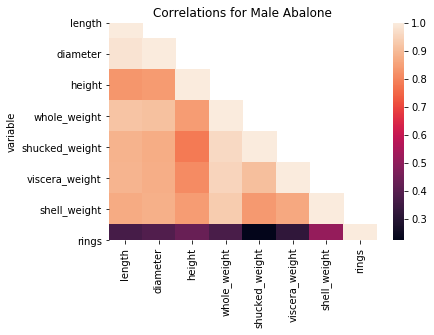

In [87]:
corm = correlations_male.set_index('variable')
ax = sns.heatmap(corm)
ax.set_title('Correlations for Male Abalone')
plt.show()

## Sampling for Training and Testing
Ensuring predictive power in large part is the result of creating a hold-out data set that we don’t train out model with.  By creating this subset of the data, we can test any model we develop against “unseen” data to prevent overfitting by our model.  This has the benefit of generating a predictive model that will generalize better.

There’s no right answer as to how much data to set aside in the test table; a 70&-30% split, weighted towards the training data, is a good rule of thumb.  This process is referred to as the [train-test split](http://madlib.apache.org/docs/latest/group__grp__train__test__split.html).


In [88]:
%%read_sql
SELECT * FROM {schema}.abalone_encoded LIMIT 2

Query started at 01:39:56 PM EST; Query executed in 0.00 m

,id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age,mature,sex_f,sex_i,sex_m
0,1,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7,8.5,0,0,0,1
1,9,0.55,0.440,0.15,0.8945,0.3145,0.1510,0.32,19,20.5,1,1,0,0


In [89]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_classif CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_classif_train CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_classif_test CASCADE;
SELECT madlib.train_test_split(
    '{schema}.abalone_encoded', -- source_table,
    '{schema}.abalone_classif', -- output_table,
    0.7, -- train_proportion,
    NULL, -- test_proportion,
    NULL, -- grouping_cols,
    'id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_i,sex_m,rings,age,mature', -- target_cols,
    FALSE, -- with_replacement,
    TRUE -- separate_output_tables
)
;
SELECT count(*) as "Number of abalone in the Training Set" FROM {schema}.abalone_classif_train
;

Query started at 01:39:56 PM EST; Query executed in 0.00 m

,Number of abalone in the Training Set
0,2924


The train/test flag is in column `split`. `1` means train, `0` means test

# Modeling
## Classification
### Logistic Regression

We’re now ready to create our first predictive model.  We’ll start with a classic logistic regression since we’ve decided that we have a classification problem.  

Note: drop one of the 1-hot-encoded variables to remove perfect collinearity

In [90]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logreg_model;
DROP TABLE IF EXISTS {schema}.abalone_logreg_model_summary;

SELECT
    madlib.logregr_train(                 --- Train the Logistic Regression Model
        '{schema}.abalone_classif_train', -- source_table,
        '{schema}.abalone_logreg_model',  -- out_table,
        'mature',                         -- dependent_varname,
        'ARRAY[
            1,
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ]'                               -- independent_varname,
        --, -- grouping_cols,
        --, -- max_iter,
        --, -- optimizer,
        --, -- tolerance,
        -- verbose
    )
;
SELECT * FROM {schema}.abalone_logreg_model_summary ;           --- Get the summary table

Query started at 01:39:57 PM EST; Query executed in 0.00 m

,method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
0,logregr,ds_training.abalone_classif_train,ds_training.abalone_logreg_model,mature,"ARRAY[\n 1,\n length,\n ...","optimizer=irls, max_iter=20, tolerance=0.0001",1,0,2924,0,None


### Now show the model that was just trained

In [91]:
%%read_sql
SELECT * FROM {schema}.abalone_logreg_model ;

Query started at 01:39:57 PM EST; Query executed in 0.00 m

,coef,log_likelihood,std_err,z_stats,p_values,odds_ratios,condition_no,num_rows_processed,num_missing_rows_skipped,num_iterations,variance_covariance
0,"[-4.72279307044238, -2.04859395060781, 8.84190...",-1041.463986,"[0.577266422133453, 2.93282565256631, 3.635888...","[-8.18130570107985, -0.698505193725113, 2.4318...","[2.80784563624385e-16, 0.484861310946669, 0.01...","[0.00889031256912871, 0.128916038533245, 6918....",121.984939,2924,0,7,"[[0.333236522122758, -0.67081595562974, -0.323..."


### Show coefficients from model

In [92]:
%%read_sql -d logreg_coefs
SELECT coef FROM {schema}.abalone_logreg_model ;

Query started at 01:39:57 PM EST; Query executed in 0.00 m

In [93]:
logreg_coef_names = (
    'intercept',
    'length',
    'diameter',
    'height',
    'whole_weight',
    'shucked_weight',
    'viscera_weight',
    'shell_weight',
    'sex_f',
    'sex_m'
)
tuple(zip(logreg_coef_names, logreg_coefs.iloc[0, 0]))

(('intercept', -4.72279307044238),
 ('length', -2.04859395060781),
 ('diameter', 8.84190292874957),
 ('height', 2.14875491097727),
 ('whole_weight', 5.98257512093647),
 ('shucked_weight', -14.9228318793796),
 ('viscera_weight', -2.06906471063968),
 ('shell_weight', 14.778016435437),
 ('sex_f', 0.927590424185395),
 ('sex_m', 0.910837224651369))

### Score the model against test data and join with the test data

Now that we have a model with coefficients, we can make predictions on records previously unseen by the model. In the current version of MADlib (1.15.1), the way to predict probability using a logistic regression model is to `CROSS JOIN` the test set records with the single-row model table. A `CROSS JOIN` produces the cartesian product between all records in both tables, meaning it pairs every record from one table with every record in the other table. In Postgres/Greenplum this can be done be explicitly using the `CROSS JOIN` statement, or you can simply list the two tables in the `FROM` clause separated by a comma. 

In [94]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logreg_test_proba;
CREATE TABLE {schema}.abalone_logreg_test_proba
AS
SELECT madlib.logregr_predict_prob(   --- Use the logistic regression model to estimate probability of mature
        coef, 
        ARRAY[
            1,
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ] 
    ) as proba,
    test.mature
FROM {schema}.abalone_classif_test test, {schema}.abalone_logreg_model model
;

SELECT *                                   --- take a look at a few of the values
FROM {schema}.abalone_logreg_test_proba
LIMIT 10
;

Query started at 01:39:57 PM EST; Query executed in 0.00 m

,proba,mature
0,0.592764,0
1,0.798996,1
2,0.065929,0
3,0.355944,0
4,0.983632,1
5,0.143651,0
6,0.136281,1
7,0.367656,1
8,0.165785,0
9,0.053601,0


### Look at the top model calculated probability vs the actual maturity

In [95]:
%%read_sql
SELECT proba as probability, mature
    FROM {schema}.abalone_logreg_test_proba
    ORDER BY probability DESC
    LIMIT 4

Query started at 01:39:57 PM EST; Query executed in 0.00 m

,probability,mature
0,0.999999,1
1,0.999997,1
2,0.999992,1
3,0.999992,1


### Calculate the area under the ROC

In [96]:
%%read_sql
drop table if exists {schema}.abalone_logreg_test_auc;
SELECT
madlib.area_under_roc(
    '{schema}.abalone_logreg_test_proba', -- table_in, 
    '{schema}.abalone_logreg_test_auc',  --table_out,
    'proba',  -- prediction_col, 
    'mature'  --observed_col, 
) as result
;
SELECT *
FROM {schema}.abalone_logreg_test_auc
;

Query started at 01:39:57 PM EST; Query executed in 0.00 m

,area_under_roc
0,0.91306


### Look at the model results for probabilities greater than 0.5

In [97]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logreg_test_predict ;
CREATE TABLE {schema}.abalone_logreg_test_predict
AS
SELECT
    (proba >= 0.5)::integer as predicted,
    mature
FROM {schema}.abalone_logreg_test_proba
;
SELECT * 
    FROM {schema}.abalone_logreg_test_predict
    LIMIT 4
;

Query started at 01:39:58 PM EST; Query executed in 0.00 m

,predicted,mature
0,1,0
1,0,0
2,1,1
3,0,1


In [98]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logreg_test_conf_matrix;
SELECT
madlib.confusion_matrix(
    '{schema}.abalone_logreg_test_predict', -- table_in
    '{schema}.abalone_logreg_test_conf_matrix', -- table_out
    'predicted',  --prediction_col
    'mature' --observation_col
)
;
SELECT                                 --- display the confusion matrix
    row_id,
    class as "Mature",
    confusion_arr[1] as "Predicted: Not Mature",
    confusion_arr[2] as "Mature"
FROM {schema}.abalone_logreg_test_conf_matrix
ORDER BY row_id
;

Query started at 01:39:58 PM EST; Query executed in 0.00 m

,row_id,Mature,Predicted: Not Mature,Mature
0,1,0,327.0,106.0
1,2,1,85.0,735.0


### Get ROC values (thresholds, true-positives, false-positives)

In [99]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_logreg_test_binary_metrics ;
SELECT
madlib.binary_classifier(
    '{schema}.abalone_logreg_test_proba', -- table_in
    '{schema}.abalone_logreg_test_binary_metrics', -- table_out
    'proba',  --prediction_col
    'mature' --observation_col
)
;
select count(*) from {schema}.abalone_logreg_test_binary_metrics
;

Query started at 01:39:58 PM EST; Query executed in 0.00 m

,count
0,1253


In [100]:
%%read_sql
SELECT *
FROM {schema}.abalone_logreg_test_binary_metrics
WHERE 
    --round(threshold::numeric, 1) = 0.5
    threshold >= 0.48 AND
    threshold <= 0.52
ORDER BY threshold;

Query started at 01:39:58 PM EST; Query executed in 0.00 m

,threshold,tp,fp,fn,tn,tpr,tnr,ppv,npv,fpr,fdr,fnr,acc,f1
0,0.480012,744.0,109.0,76.0,324.0,0.907317,0.748268,0.872216,0.810000,0.251732,0.127784,0.092683,0.852354,0.889420
1,0.481883,743.0,109.0,77.0,324.0,0.906098,0.748268,0.872066,0.807980,0.251732,0.127934,0.093902,0.851556,0.888756
2,0.483914,743.0,108.0,77.0,325.0,0.906098,0.750577,0.873090,0.808458,0.249423,0.126910,0.093902,0.852354,0.889288
3,0.486990,742.0,108.0,78.0,325.0,0.904878,0.750577,0.872941,0.806452,0.249423,0.127059,0.095122,0.851556,0.888623
4,0.487654,741.0,108.0,79.0,325.0,0.903659,0.750577,0.872792,0.804455,0.249423,0.127208,0.096341,0.850758,0.887957
5,0.489967,740.0,108.0,80.0,325.0,0.902439,0.750577,0.872642,0.802469,0.249423,0.127358,0.097561,0.849960,0.887290
6,0.490897,739.0,108.0,81.0,325.0,0.901220,0.750577,0.872491,0.800493,0.249423,0.127509,0.098780,0.849162,0.886623
7,0.493017,738.0,108.0,82.0,325.0,0.900000,0.750577,0.872340,0.798526,0.249423,0.127660,0.100000,0.848364,0.885954
8,0.494264,738.0,107.0,82.0,326.0,0.900000,0.752887,0.873373,0.799020,0.247113,0.126627,0.100000,0.849162,0.886486
9,0.494288,737.0,107.0,83.0,326.0,0.898780,0.752887,0.873223,0.797066,0.247113,0.126777,0.101220,0.848364,0.885817


The `-d` flag for the `%%read_sql` magic command below keeps it from displaying the query result, which in this case is many rows that we want stored in the `logreg_metrics` dataframe but don't want to print the whole thing. 

In [101]:
%%read_sql -d logreg_metrics
SELECT *
FROM {schema}.abalone_logreg_test_binary_metrics
ORDER BY threshold

Query started at 01:39:58 PM EST; Query executed in 0.00 m

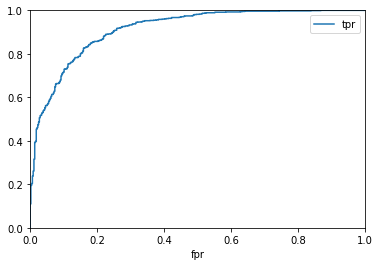

In [102]:
logreg_metrics.plot('fpr', 'tpr',xlim=(0.,1.),ylim=(0.,1.))

### Random Forest Classifier

In [103]:
%%read_sql
SELECT * 
FROM {schema}.abalone_classif_train
LIMIT 5

Query started at 01:39:59 PM EST; Query executed in 0.00 m

,id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_i,sex_m,rings,age,mature
0,9,0.550,0.440,0.150,0.8945,0.3145,0.151,0.320,1,0,0,19,20.5,1
1,13,0.535,0.405,0.145,0.6845,0.2725,0.171,0.205,1,0,0,10,11.5,1
2,15,0.500,0.400,0.130,0.6645,0.2580,0.133,0.240,0,0,1,12,13.5,1
3,19,0.450,0.320,0.100,0.3810,0.1705,0.075,0.115,0,0,1,9,10.5,1
4,24,0.615,0.480,0.165,1.1615,0.5130,0.301,0.305,1,0,0,10,11.5,1


In [104]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_model;
DROP TABLE IF EXISTS {schema}.abalone_rf_model_group;
DROP TABLE IF EXISTS {schema}.abalone_rf_model_summary;
SELECT
madlib.forest_train(
    '{schema}.abalone_classif_train',  -- training_table_name
    '{schema}.abalone_rf_model',  -- output_table_name
    'id',  -- id_col_name
    'mature',  -- dependent_variable
    'length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_m',  -- list_of_features
    NULL,  -- list_of_features_to_exclude
    NULL,  -- grouping_columns
    10  -- number of trees
)


Query started at 01:39:59 PM EST; Query executed in 0.08 m

,forest_train
0,


In [105]:
%%read_sql
SELECT * 
FROM {schema}.abalone_rf_model
LIMIT 4

Query started at 01:40:04 PM EST; Query executed in 0.01 m

,gid,sample_id,tree
0,1,1,\000\000\000\000\013\000\002\000\000\000\000\0...
1,1,2,\000\000\000\000\012\000\002\000\000\000\000\0...
2,1,3,\000\000\000\000\013\000\002\000\000\000\000\0...
3,1,4,\000\000\000\000\013\000\002\000\000\000\000\0...


In [106]:
%%read_sql rf_tree1
SELECT madlib.get_tree(
    '{schema}.abalone_rf_model',
    1,
    1,
    FALSE  -- return results in dot_format? (boolean)
) 

Query started at 01:40:04 PM EST; Query executed in 0.00 m

,get_tree
0,-------------------------------------\n - E...


In [107]:
print(rf_tree1.iloc[0,0])

-------------------------------------
    - Each node represented by 'id' inside ().
    - Each internal nodes has the split condition at the end, while each
        leaf node has a * at the end.
    - For each internal node (i), its child nodes are indented by 1 level
        with ids (2i+1) for True node and (2i+2) for False node.
    - Number of (weighted) rows for each response variable inside [].'
        The response label order is given as ['0', '1'].
        For each leaf, the prediction is given after the '-->'
        
-------------------------------------
(0)[ 996 1985]  diameter <= 0.375
   (1)[703 304]  whole_weight <= 0.277
      (3)[369  44]  shell_weight <= 0.05
         (7)[216   1]  shell_weight <= 0.038
            (15)[154   0]  * --> 0
            (16)[62  1]  sex_m in {0}
               (33)[47  0]  * --> 0
               (34)[15  1]  * --> 0
         (8)[153  43]  length <= 0.355
            (17)[44 26]  * --> 0
            (18)[109  17]  length <= 0.375
        

In [108]:
%%read_sql rf_tree1_dot
SELECT madlib.get_tree(
    '{schema}.abalone_rf_model',
    1,
    1,
    TRUE  -- return results in dot_format? (boolean)
) 

Query started at 01:40:05 PM EST; Query executed in 0.00 m

,get_tree
0,"digraph ""Classification tree for ds_training.a..."


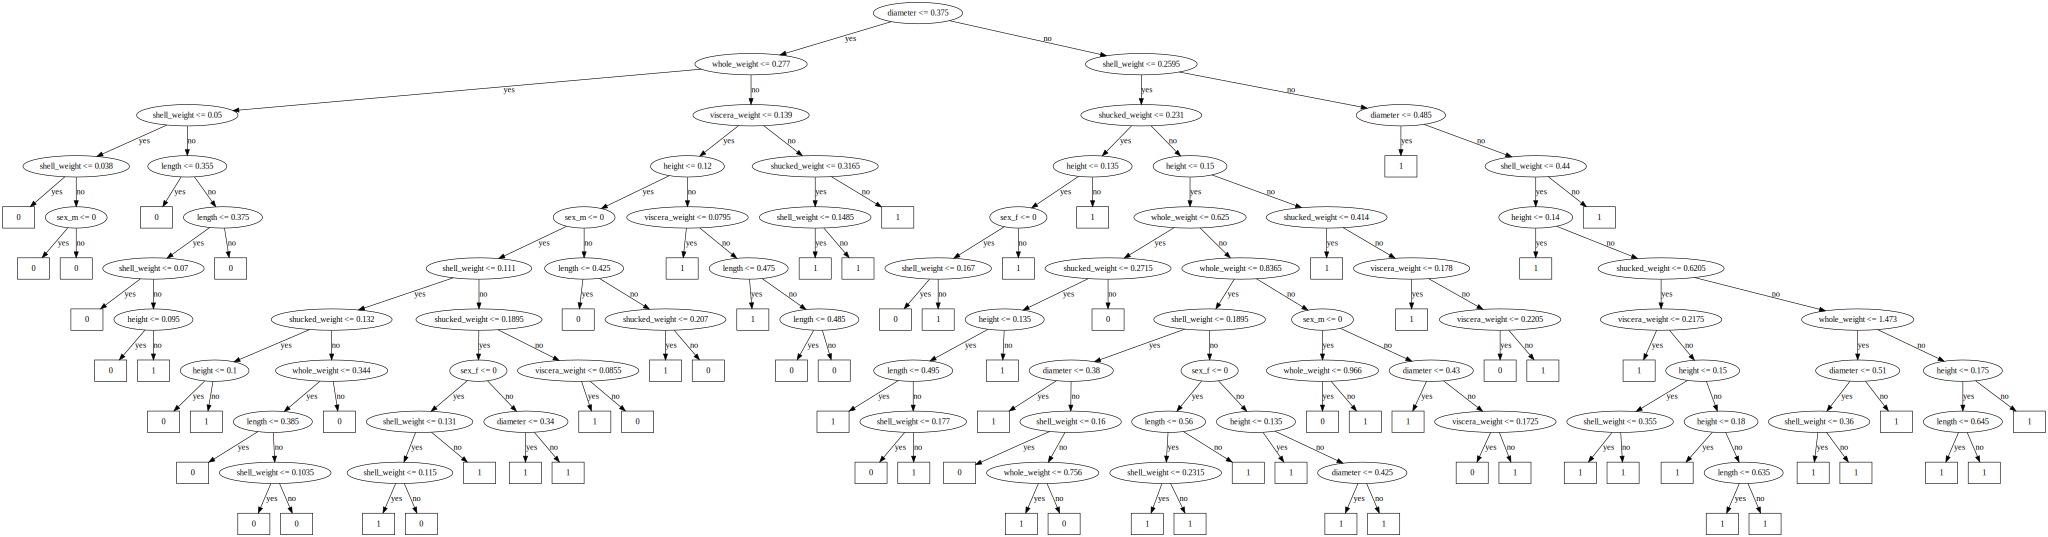

In [109]:
if graphviz_installed:
    rf_dot_source = graphviz.Source(rf_tree1_dot.iloc[0,0])
    display(rf_dot_source)

In [110]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_importances;
SELECT madlib.get_var_importance(
    '{schema}.abalone_rf_model',  -- model_table
    '{schema}.abalone_rf_importances'  -- output_table
)
;
SELECT *
FROM {schema}.abalone_rf_importances
ORDER BY impurity_var_importance DESC
;

Query started at 01:40:05 PM EST; Query executed in 0.00 m

,feature,oob_var_importance,impurity_var_importance
0,shell_weight,32.447907,23.219982
1,shucked_weight,12.282987,15.710581
2,viscera_weight,0.577569,12.474321
3,whole_weight,12.016442,12.410879
4,length,16.079011,10.432168
5,height,0.000000,9.992856
6,diameter,11.648865,9.446434
7,sex_m,8.040152,3.621158
8,sex_f,6.907068,2.691620


In [111]:
%%read_sql -d
DROP TABLE IF EXISTS {schema}.abalone_rf_test_proba;
SELECT
madlib.forest_predict(
    '{schema}.abalone_rf_model',  -- random_forest_model
    '{schema}.abalone_classif_test',  -- new_data_table
    '{schema}.abalone_rf_test_proba',  -- output_table
    'prob'  -- type
)
;

Query started at 01:40:05 PM EST; Query executed in 0.01 m

## Look at some of the predictions

In [112]:
%%read_sql
SELECT * 
FROM {schema}.abalone_rf_test_proba
LIMIT 5

Query started at 01:40:06 PM EST; Query executed in 0.00 m

,id,estimated_prob_0,estimated_prob_1
0,1,0.6,0.4
1,3,0.3,0.7
2,21,1.0,0.0
3,23,0.2,0.8
4,25,0.1,0.9


In [113]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_test_predict_actual;
CREATE TABLE {schema}.abalone_rf_test_predict_actual
AS
SELECT 
    test.id,
    prob.estimated_prob_1,
    prob.estimated_prob_1 >= 0.5 as predicted_class,
    test.mature as actual_class
FROM 
    {schema}.abalone_rf_test_proba prob
INNER JOIN
    {schema}.abalone_classif_test test
ON
    prob.id = test.id

Query started at 01:40:06 PM EST; Query executed in 0.00 m

In [114]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_test_binary_metrics;
SELECT
madlib.binary_classifier(
    '{schema}.abalone_rf_test_predict_actual', -- table_in
    '{schema}.abalone_rf_test_binary_metrics', -- table_out
    'estimated_prob_1',  --prediction_col
    'actual_class' --observation_col
)
;
SELECT * 
FROM {schema}.abalone_rf_test_binary_metrics
ORDER BY threshold
LIMIT 15
;

Query started at 01:40:06 PM EST; Query executed in 0.00 m

,threshold,tp,fp,fn,tn,tpr,tnr,ppv,npv,fpr,fdr,fnr,acc,f1
0,0.0,820.0,433.0,0.0,0.0,1.000000,0.000000,0.654429,NaN,1.000000,0.345571,0.000000,0.654429,0.791124
1,0.1,804.0,243.0,16.0,190.0,0.980488,0.438799,0.767908,0.922330,0.561201,0.232092,0.019512,0.793296,0.861275
2,0.2,793.0,194.0,27.0,239.0,0.967073,0.551963,0.803445,0.898496,0.448037,0.196555,0.032927,0.823623,0.877698
3,0.3,786.0,170.0,34.0,263.0,0.958537,0.607390,0.822176,0.885522,0.392610,0.177824,0.041463,0.837191,0.885135
4,0.4,771.0,160.0,49.0,273.0,0.940244,0.630485,0.828142,0.847826,0.369515,0.171858,0.059756,0.833200,0.880640
5,0.5,763.0,148.0,57.0,285.0,0.930488,0.658199,0.837541,0.833333,0.341801,0.162459,0.069512,0.836393,0.881571
6,0.6,750.0,115.0,70.0,318.0,0.914634,0.734411,0.867052,0.819588,0.265589,0.132948,0.085366,0.852354,0.890208
7,0.7,728.0,95.0,92.0,338.0,0.887805,0.780600,0.884569,0.786047,0.219400,0.115431,0.112195,0.850758,0.886184
8,0.8,688.0,79.0,132.0,354.0,0.839024,0.817552,0.897001,0.728395,0.182448,0.102999,0.160976,0.831604,0.867045
9,0.9,655.0,63.0,165.0,370.0,0.798780,0.854503,0.912256,0.691589,0.145497,0.087744,0.201220,0.818037,0.851756


In [115]:
%%read_sql -d rf_metrics         
SELECT fpr, tpr                                -- collect the false positive and true positive rates
FROM {schema}.abalone_rf_test_binary_metrics
ORDER BY threshold

Query started at 01:40:06 PM EST; Query executed in 0.00 m

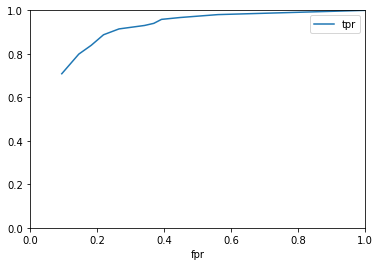

In [116]:
rf_metrics.plot('fpr', 'tpr',xlim=(0.,1.), ylim=(0.,1.))

In [117]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_test_auc CASCADE;
SELECT
madlib.area_under_roc(
    '{schema}.abalone_rf_test_predict_actual', -- table_in
    '{schema}.abalone_rf_test_auc', -- table_out
    'estimated_prob_1',  --prediction_col
    'actual_class' --observation_col
) as result
;

SELECT * FROM {schema}.abalone_rf_test_auc ;   -- look at the AUC for the random forest model

Query started at 01:40:06 PM EST; Query executed in 0.00 m

,area_under_roc
0,0.891868


## Train another version of the Random Forest Model

In [118]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_model_v2 CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_rf_model_v2_group CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_rf_model_v2_summary CASCADE;
SELECT
madlib.forest_train(
    '{schema}.abalone_classif_train',  -- training_table_name
    '{schema}.abalone_rf_model_v2',  -- output_table_name
    'id',  -- id_col_name
    'mature',  -- dependent_variable
    'length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_m',  -- list_of_features
    NULL,  -- list_of_features_to_exclude
    NULL,  -- grouping_columns
    10,  -- number of trees
    NULL,  -- num_random_features
    TRUE,  -- importance
    1,  -- num_permutations
    4,  -- max_tree_depth
    NULL,  -- min_split
    NULL,  -- min_bucket
    NULL,  -- num_splits
    NULL,  -- null_handling_params
    TRUE,  -- verbose
    NULL   -- sample_ratio
)
;
DROP TABLE IF EXISTS {schema}.abalone_rf_v2_test_proba;
SELECT
madlib.forest_predict(
    '{schema}.abalone_rf_model_v2',  -- random_forest_model
    '{schema}.abalone_classif_test',  -- new_data_table
    '{schema}.abalone_rf_v2_test_proba',  -- output_table
    'prob'  -- type
)
;
SELECT * FROM {schema}.abalone_rf_v2_test_proba
LIMIT 4
;

Query started at 01:40:10 PM EST; Query executed in 0.00 m

,id,estimated_prob_0,estimated_prob_1
0,1,0.7,0.3
1,3,0.3,0.7
2,21,1.0,0.0
3,23,0.1,0.9


In [119]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_rf_v2_test_predict_actual;
CREATE TABLE {schema}.abalone_rf_v2_test_predict_actual
AS
SELECT 
    test.id,
    prob.estimated_prob_1,
    prob.estimated_prob_1 >= 0.5 as predicted_class,
    test.mature as actual_class
FROM 
    {schema}.abalone_rf_v2_test_proba prob
INNER JOIN
    {schema}.abalone_classif_test test
ON
    prob.id = test.id
;
DROP TABLE IF EXISTS {schema}.abalone_rf_v2_test_auc CASCADE;
SELECT
madlib.area_under_roc(
    '{schema}.abalone_rf_v2_test_predict_actual', -- table_in
    '{schema}.abalone_rf_v2_test_auc', -- table_out
    'estimated_prob_1',  --prediction_col
    'actual_class' --observation_col
) as result
;  
SELECT * FROM {schema}.abalone_rf_v2_test_auc
;

Query started at 01:40:10 PM EST; Query executed in 0.00 m

,area_under_roc
0,0.869871


## Regression

Before our target variable was a binary one that we constructed to represent maturity. An abalone was either mature or not mature. Now let's predict its age instead of the binary target. 

### Linear Regression

In [120]:
%%read_sql
SELECT * 
FROM {schema}.abalone_classif_train
LIMIT 2

Query started at 01:40:10 PM EST; Query executed in 0.00 m

,id,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_f,sex_i,sex_m,rings,age,mature
0,9,0.550,0.440,0.150,0.8945,0.3145,0.151,0.320,1,0,0,19,20.5,1
1,13,0.535,0.405,0.145,0.6845,0.2725,0.171,0.205,1,0,0,10,11.5,1


In [121]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_linreg_model;
DROP TABLE IF EXISTS {schema}.abalone_linreg_model_summary;
SELECT madlib.linregr_train(
    '{schema}.abalone_classif_train',  -- source_table
    '{schema}.abalone_linreg_model',  -- out_table
    'age',  -- dependent_varname
    'ARRAY[
        1,
        length,
        diameter,
        height,
        whole_weight,
        shucked_weight,
        viscera_weight,
        shell_weight,
        sex_f,
        sex_m
    ]',  -- independent_varname
    NULL,  -- grouping_cols
    TRUE  -- heteroskedasticity_option
)
;
SELECT * FROM {schema}.abalone_linreg_model
LIMIT 10
;

Query started at 01:40:11 PM EST; Query executed in 0.00 m

,coef,r2,std_err,t_stats,p_values,condition_no,bp_stats,bp_p_value,num_rows_processed,num_missing_rows_skipped,variance_covariance
0,"[4.54870374016097, -0.87728046764869, 12.46621...",0.534309,"[0.312924262571174, 2.10854444624812, 2.588178...","[14.5361171511153, -0.416059746432993, 4.81659...","[2.86403408097293e-46, 0.677396921173308, 1.53...",135.662298,305.159525,2.099215e-60,2924,0,"[[0.0979215941057132, -0.25632069528423, -0.00..."


### Look at the predictions from the Linear Regression Model

In [122]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_linreg_test_predict;
CREATE TABLE {schema}.abalone_linreg_test_predict
AS
SELECT 
    test.id,
    madlib.linregr_predict(
        coef, 
        ARRAY[
            1,
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ] 
    ) as predicted_age,
    test.age as actual_age
FROM {schema}.abalone_classif_test test, {schema}.abalone_linreg_model model
;
SELECT * FROM {schema}.abalone_linreg_test_predict
LIMIT 5
;

Query started at 01:40:11 PM EST; Query executed in 0.00 m

,id,predicted_age,actual_age
0,3110,9.242874,9.5
1,2728,7.274010,9.5
2,3371,9.206513,11.5
3,1648,12.309598,11.5
4,1123,9.537110,9.5


In [123]:
%%read_sql
drop table if exists {schema}.abalone_linreg_test_predict_mse;
SELECT madlib.mean_squared_error(
    '{schema}.abalone_linreg_test_predict',  -- table_in
    '{schema}.abalone_linreg_test_predict_mse',  -- table_out
    'predicted_age',  -- prediction_col
    'actual_age'  -- observed_col
) as result
;


Query started at 01:40:11 PM EST; Query executed in 0.00 m

,result
0,


In [124]:
%%read_sql linreg_mse
SELECT * FROM {schema}.abalone_linreg_test_predict_mse ;

Query started at 01:40:11 PM EST; Query executed in 0.00 m

,mean_squared_error
0,4.985198


In [125]:
# Root Mean Squared Error (RMSE)
math.sqrt(linreg_mse.iloc[0,0])

2.232755693456577

### Elastic Net Regression

Elastic Net Regression is linear regression with penalties assigned to the size of the coefficients. 

Note that MADlib's elastic net automatically fits an intercept, so you shouldn't include an explicit intercept column of 1's in your independent variable array.

In [126]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_elasticnet_model CASCADE;
DROP TABLE IF EXISTS {schema}.abalone_elasticnet_model_summary CASCADE;
SELECT madlib.elastic_net_train( 
    '{schema}.abalone_classif_train',  -- tbl_source
    '{schema}.abalone_elasticnet_model',  -- tbl_result
    'age',  -- col_dep_var
    'ARRAY[
        length,
        diameter,
        height,
        whole_weight,
        shucked_weight,
        viscera_weight,
        shell_weight,
        sex_f,
        sex_m
    ]',  -- col_ind_var
    'gaussian',  -- regress_family
    0.5,  -- alpha
    0.5,  -- lambda_value
    TRUE  -- standardize
    --,  -- grouping_col
    --,  -- optimizer
    --,  -- optimizer_params
    --,  -- excluded
    --,  -- max_iter
      -- tolerance
)

Query started at 01:40:11 PM EST; Query executed in 0.04 m

,elastic_net_train
0,


In [127]:
%%read_sql
SELECT * FROM {schema}.abalone_elasticnet_model

Query started at 01:40:14 PM EST; Query executed in 0.00 m

,family,features,features_selected,coef_nonzero,coef_all,intercept,log_likelihood,standardize,iteration_run
0,gaussian,"[[1], [2], [3], [4], [5], [6], [7], [8], [9]]","[[1], [2], [3], [7], [8]]","[0.977669380796, 3.23801466363, 8.22532237757,...","[0.977669380796, 3.23801466363, 8.22532237757,...",6.964634,-3.756691,True,219


In [128]:
%%read_sql
SELECT * FROM {schema}.abalone_elasticnet_model_summary

Query started at 01:40:14 PM EST; Query executed in 0.00 m

,method,source_table,out_table,dependent_varname,independent_varname,family,alpha,lambda_value,grouping_col,num_all_groups,num_failed_groups
0,elastic_net,ds_training.abalone_classif_train,ds_training.abalone_elasticnet_model,age,"ARRAY[\n length,\n diameter,\n ...",gaussian,0.5,0.5,NULL,1,0


In [129]:
%%read_sql
DROP TABLE IF EXISTS {schema}.abalone_elasticnet_test_predict;
CREATE TABLE {schema}.abalone_elasticnet_test_predict
AS
SELECT 
    test.id,
    madlib.elastic_net_gaussian_predict(
        model.coef_all, 
        model.intercept,
        ARRAY[
            length,
            diameter,
            height,
            whole_weight,
            shucked_weight,
            viscera_weight,
            shell_weight,
            sex_f,
            sex_m
        ] 
    ) as predicted_age,
    test.age as actual_age
FROM {schema}.abalone_classif_test test, {schema}.abalone_elasticnet_model model
;

Query started at 01:40:14 PM EST; Query executed in 0.00 m

In [130]:
%%read_sql
SELECT * FROM {schema}.abalone_elasticnet_test_predict
LIMIT 5

Query started at 01:40:15 PM EST; Query executed in 0.00 m

,id,predicted_age,actual_age
0,1201,12.334619,9.5
1,1893,11.812074,11.5
2,1222,9.119629,8.5
3,3025,10.258044,8.5
4,2969,13.342604,11.5


In [131]:
%%read_sql elasticnet_mse
DROP TABLE IF EXISTS {schema}.abalone_elasticnet_test_predict_mse;
SELECT madlib.mean_squared_error(
    '{schema}.abalone_elasticnet_test_predict',  -- table_in
    '{schema}.abalone_elasticnet_test_predict_mse',  -- table_out
    'predicted_age',  -- prediction_col
    'actual_age'  -- observed_col
) 
;
SELECT * FROM {schema}.abalone_elasticnet_test_predict_mse
;

Query started at 01:40:15 PM EST; Query executed in 0.00 m

,mean_squared_error
0,6.683677


In [132]:
# Root Mean Squared Error (RMSE)
math.sqrt(elasticnet_mse.iloc[0,0])

2.5852808959748783

### Check to see if the estimates have bias by averaging the difference of predicted and actual age

In [144]:
%%read_sql
select avg(predicted_age - actual_age)
as "Mean Error" from {schema}.abalone_elasticnet_test_predict;

Query started at 02:47:19 PM EST; Query executed in 0.00 m

,Mean Error
0,-0.015791
